# Using the Chess.com Public API for Personal Chess Analytics

### While chess.com has a great number of tools to help you analyze individual games, their tooling for doing inter-game analysis like the opening database are not as good to do high-level understandings of mistakes or for strategy building. In this notebook, we give an example from my games using the chess.com API to build analytics and understanding of potential problems with my openings and gameplay.

### I've added some parameters to help you do your own analysis. The good news is that the chess.com API is truly public so we don't need any special API keys to pull down games. This also uses stockfish to give evaluations of positions, so you'll need to give a directory for where your stockfish is located (you can download stockfish for your system here [https://stockfishchess.org/])

### As with any use of engines or analysis of games, you should always be following chess.com's fair play rules and instead be using this for preparation before and after games and never during games. Chess.com has a good guide on fair play here [https://support.chess.com/article/648-what-do-i-need-to-know-about-fair-play-on-chess-com].

In [233]:
USERNAME = 'rdubwiley1990'
STOCKFISH_DIR = './stockfish/stockfish'
STOCKFISH_DEPTH = 12
MONTHS_TO_PULL = [
    {'year':'2021', 'month':'03'},
    {'year':'2021', 'month':'04'},
    {'year':'2021', 'month':'05'},
]

### We import the python wrapper for the chess.com library. I also had some problems with asyncio loops so I use nest_asyncio to fix those issues. I run a sample response to get my profile to ensure that we've downloaded the API wrapper.

In [234]:
from chessdotcom import get_player_profile
import nest_asyncio
from stockfish import Stockfish

#Issue with vscode notebooks that I got an async loop error
nest_asyncio.apply()

stockfish = Stockfish(STOCKFISH_DIR)
#Default on chess.com is 20 moves, but might want to set depth lower for better computation times
stockfish.set_depth(STOCKFISH_DEPTH)

response = get_player_profile(USERNAME)
player_name = response.json['player']['username']
player_name

'rdubwiley1990'

### We now pull down our games using the MONTHS_TO_PULL variable that was set above. I've been most active playing games in the past three months so that's where we'll get our games.

In [235]:
from chessdotcom import get_player_games_by_month, get_player_games_by_month_pgn

def get_games(username, month_list):
    all_games = []
    for month_data in month_list:
        games = get_player_games_by_month(username, year=month_data['year'], month=month_data['month']).games
        all_games += games
    return all_games


games = get_games(
    USERNAME, 
    MONTHS_TO_PULL
)
print(f'Found {len(games)} games')

Found 217 games


### These are the main functions of our analysis and does a lot of similar things that chess.com does for game analysis including getting an engine analysis for each move, getting material evaluations, and getting time spent on each move. We use stockfish to do the engine evaluations and depending on how deep you set the engine and how many games you have it could take quite a white to parse through the games.

In [236]:
from collections import Counter
import copy
from datetime import datetime
import io

import chess.pgn
from tqdm.notebook import tqdm

def get_material_evaluation(board):
    piece_list = [
        ('pawn', 'p', 8, 1),
        ('bishop', 'b', 2, 3),
        ('knight', 'n', 2, 3),
        ('rook', 'r', 2, 5),
        ('queen', 'q', 1, 9)
    ]
    board_str = str(board)
    count = Counter(board_str)
    captured_pieces = {
        'white': {},
        'black': {}
    }
    score = 0
    for piece in piece_list:
        piece_count = count[piece[1]]
        score -= piece_count*piece[3]
        captured_pieces['black'][piece[0]] = piece[2]-piece_count
        piece_count = count[piece[1].upper()]
        score += piece_count*piece[3]
        captured_pieces['white'][piece[0]] = piece[2]-piece_count
    return score, captured_pieces


def get_engine_evaluation(moves):
    stockfish.set_position(moves)
    evaluation = stockfish.get_evaluation()
    #Engine outputs centipawns so we convert them into pawns
    if evaluation['type'] == 'cp':
        evaluation['type'] = 'p'
        evaluation['value'] = evaluation['value']/100
    best_move = stockfish.get_best_move()
    return {'best_move': best_move, 'evaluation': evaluation}


def parse_game_data(game, username):
    """
        Find which color the user is playing
        Get the game type and time control
        Load pgn into a game object
        player moves and opponent moves
    """
    if game.white.username == username:
        player_color = 'white'
        player_elo = game.white.rating
        opponent = game.black.username
        opponent_elo = game.black.rating
        elo_differential = game.white.rating - game.black.rating
        result = game.white.result
    else:
        player_color = 'black'
        player_elo = game.black.rating
        opponent_elo = game.white.rating
        opponent = game.white.username
        elo_differential = game.black.rating - game.white.rating
        result = game.black.result
    end_time = datetime.fromtimestamp(game.end_time)
    time_class = game.time_class
    time_control = game.time_control
    
    if "+" in time_control:
        starting_time = int(time_control.split("+")[0])
        increment = int(time_control.split("+")[1])
    else:
        starting_time = int(time_control)
        increment = 0
    game_pgn = game.pgn
    read_game = chess.pgn.read_game(io.StringIO(game_pgn))
    moves = [ move for move in read_game.mainline() ]
    boards = [ move.board() for move in moves ]
    material_evals = [ get_material_evaluation(board) for board in boards ]
    material_eval_scores = [ item[0] for item in material_evals ]
    if game.white.username == username:
        player_material_scores = material_eval_scores
    else:
        player_material_scores = [ -1*item for item in material_eval_scores ]
    material_eval_captures = [ item[1] for item in material_evals ]
    moves_uci = [ str(move) for move in read_game.mainline_moves() ]
    moves_uci_stacked = [ moves_uci[:i+1] for i, moves in enumerate(moves_uci)]
    engine_evaluations = [ get_engine_evaluation(move) for move in moves_uci_stacked ]
    engine_eval_scores = [ item['evaluation'] for item in engine_evaluations ]
    if game.white.username == username:
        player_engine_eval_scores = engine_eval_scores
    else:
        player_engine_eval_scores = copy.deepcopy(engine_eval_scores)
        for item in player_engine_eval_scores:
            if item['type'] == 'p':
                item['value'] = -item['value']
    engine_eval_best_moves = [ item['best_move'] for item in engine_evaluations ]
    moves_alg = [ move.san() for move in read_game.mainline() ]
    moves_clock = [ move.clock() for move in read_game.mainline() ]
    white_clock = moves_clock[0::2]
    white_prev_clocks = [starting_time] + white_clock[:-1]
    #Need to add increment
    white_prev_clocks = [ time+increment for time in white_prev_clocks ]
    white_prev_clocks[0] -= increment
    white_move_times = [ round(item[1]-item[0],2) for item in zip(white_clock, white_prev_clocks)]
    black_clock = moves_clock[1::2]
    black_prev_clocks = [starting_time] + black_clock[:-1]
    #Need to add increment
    black_prev_clocks = [ time+increment for time in black_prev_clocks ]
    black_prev_clocks[0] -= increment
    black_move_times = [ round(item[1]-item[0],2) for item in zip(black_clock, white_prev_clocks) ]
    move_times = [val for tup in zip(white_move_times, black_move_times) for val in tup]
    #Need to correct for an odd number of moves
    if len(moves) %2 != 0:
        move_times += [white_move_times[-1]]
    move_descriptions = [
        {
            'move_uci': move,
            'move_alg': moves_alg[i],
            'board': boards[i],
            'move_color': 'white' if i%2==0 else 'black',
            'move_player': game.white.username if i%2==0 else game.black.username,
            'move_time': move_times[i],
            'move_clock': moves_clock[i],
            'material_eval': material_eval_scores[i],
            'player_material_eval': player_material_scores[i],
            'captured_pieces': material_eval_captures[i],
            'engine_eval': engine_eval_scores[i],
            'player_engine_eval': player_engine_eval_scores[i],
            'best_move': engine_eval_best_moves[i],

        }
        for i, move in enumerate(moves_uci)
    ]
    player_move_descriptions = [ md for md in move_descriptions if md['move_player']==username]
    return {
        'player': username,
        'opponent': opponent,
        'player_color': player_color,
        'player_elo': player_elo,
        'opponent_elo': opponent_elo,
        'elo_differential': elo_differential,
        'result': result,
        'date': end_time.date(),
        'time_class': time_class,
        'time_control': time_control,
        'game': read_game,
        'game_pgn': game_pgn,
        'moves': moves,
        'moves_uci': moves_uci,
        'move_descriptions': move_descriptions,
        'player_move_descriptions': player_move_descriptions
    }

parsed_games = []
#Might take a while for the engine to calculate moves (depending on engine depth)
for game in tqdm(games):
    parsed_games.append(parse_game_data(game, player_name))


  0%|          | 0/217 [00:00<?, ?it/s]

Exception ignored in: <function Stockfish.__del__ at 0x7f276b02da60>
Traceback (most recent call last):
  File "/home/ryan/python/chess/venv/lib/python3.8/site-packages/stockfish/models.py", line 291, in __del__
    self._put("quit")
  File "/home/ryan/python/chess/venv/lib/python3.8/site-packages/stockfish/models.py", line 72, in _put
    self.stockfish.stdin.flush()
BrokenPipeError: [Errno 32] Broken pipe


### Because using stockfish is computationally intensive, I pickled the parsed games in case I want to do further analysis on these games without having to run it all again.

In [238]:
#Checkpointing because parsing with the engine takes a while

import cloudpickle

with open('parsed_games.pkl', 'wb') as f:
    cloudpickle.dump({'games': parsed_games}, f)

### Now that we have all of the analysis on our individual games, we can start building plots of our games.

### My interest in looking at patterns between games came from an observation that I was getting down a pawn in the early game as white and my opponents were able to take that advantage all the way to endgames where they would use that extra pawn to promote and win the game. So, I want to be able to detect those types of games and find possible opening mistakes that I'm regularly making.

### As such, we make a function that plots the material advantage over time for a game.

<AxesSubplot:>

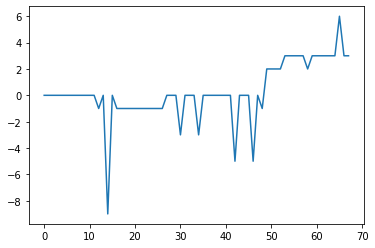

In [239]:
import pandas as pd

def get_material_score_series(parsed_game):
    return [ move['player_material_eval'] for move in parsed_game['move_descriptions']]

material_series = get_material_score_series(parsed_games[-4])
pd.Series(material_series).plot()

### We do the same thing with the stockfish evaluations. We have to adjust the outputs from stockfish as they give evaluations for upcoming checkmates that need to be converted to pawn values (the stockfish engine outputs centipawn evaluations, but I chose in the previous analysis functions to covert them to pawns). I chose 100 as that seemed like a relatively extreme amount that would be similar to other clearly-won positions in the data.

<AxesSubplot:>

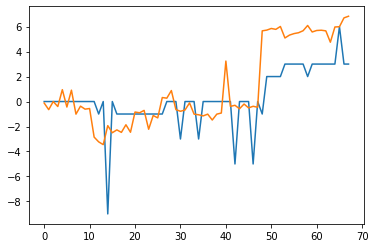

In [240]:
def get_adjusted_engine_eval(engine_eval, player_color, result):
    #Need to give a score for checkmates
    if engine_eval['type'] == 'mate':
        if result == 'win':
            return 100
        else:
            return -100

    else:
        return engine_eval['value']


def get_adjusted_engine_eval_series(parsed_game):
    player_color = parsed_game['player_color']
    result = parsed_game['result']
    return [ 
        get_adjusted_engine_eval(
            move['player_engine_eval'], player_color, result
        ) for move in parsed_game['move_descriptions']
    ]

engine_series = get_adjusted_engine_eval_series(parsed_games[-4])
pd.Series(material_series).plot()
pd.Series(engine_series).plot()

### With our functions to plot games we can plot a few to see what they look like. Here's the material evaluations.

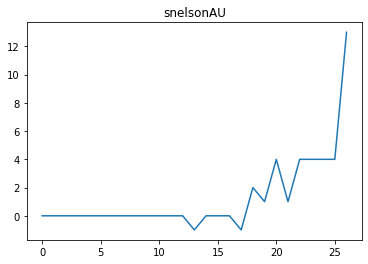

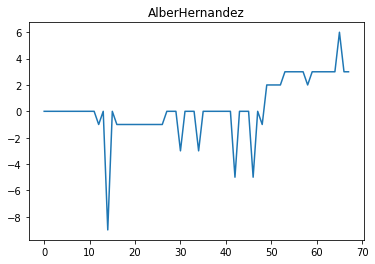

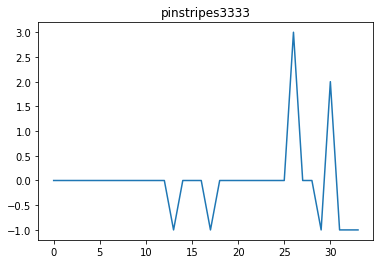

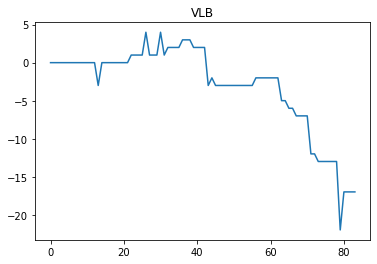

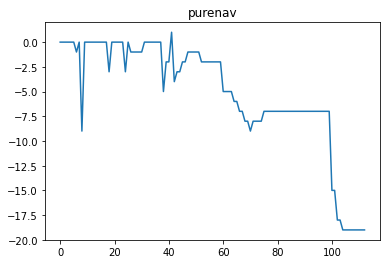

In [242]:
import matplotlib.pyplot as plt

material_series_list = [ get_material_score_series(game) for game in parsed_games ]
for i, series in enumerate(material_series_list[-5:]):
    plt.figure()
    pd.Series(series).plot(title=f'{parsed_games[-5+i]["opponent"]}')

### And here's a few engine evaluation series.

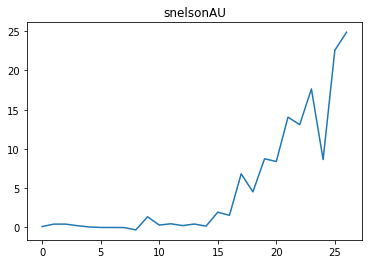

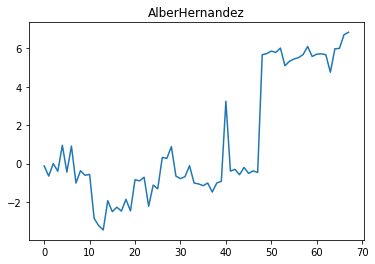

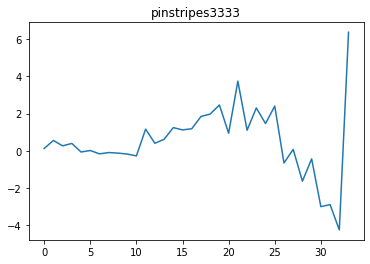

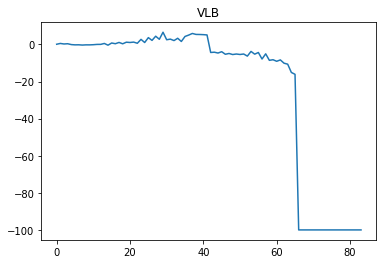

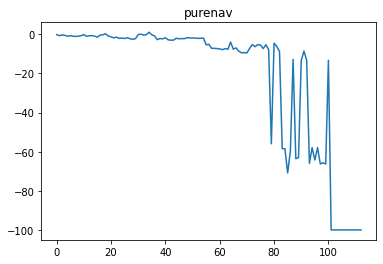

In [241]:
import matplotlib.pyplot as plt

engine_series_list = [ get_adjusted_engine_eval_series(game) for game in parsed_games ]
for i, series in enumerate(engine_series_list[-5:]):
    plt.figure()
    pd.Series(series).plot(title=f'{parsed_games[-5+i]["opponent"]}')

### We can also do some game statistics similar to what chess.com does for each time class. Here's a breakdown of games by result.

In [243]:
results = [ (game['time_class'], game['player_color'], game['result']) for game in parsed_games]
Counter(results)

Counter({('rapid', 'white', 'win'): 21,
         ('rapid', 'white', 'checkmated'): 17,
         ('rapid', 'black', 'checkmated'): 13,
         ('rapid', 'black', 'win'): 31,
         ('rapid', 'black', 'agreed'): 2,
         ('rapid', 'white', 'resigned'): 6,
         ('rapid', 'black', 'resigned'): 7,
         ('blitz', 'black', 'checkmated'): 21,
         ('blitz', 'white', 'checkmated'): 15,
         ('blitz', 'black', 'resigned'): 5,
         ('blitz', 'white', 'insufficient'): 1,
         ('blitz', 'white', 'win'): 32,
         ('blitz', 'black', 'win'): 24,
         ('rapid', 'white', 'repetition'): 3,
         ('blitz', 'white', 'repetition'): 2,
         ('blitz', 'white', 'resigned'): 8,
         ('rapid', 'black', 'repetition'): 2,
         ('blitz', 'black', 'stalemate'): 1,
         ('blitz', 'white', 'stalemate'): 1,
         ('blitz', 'black', 'agreed'): 1,
         ('blitz', 'white', 'agreed'): 1,
         ('rapid', 'white', 'agreed'): 1,
         ('rapid', 'white', 'sta

### We can also look at massive swings in the evaluation by constructing difference series for our games. To get that we need to get the stockfish evaluation when the game starts.

In [244]:
stockfish.set_position([])
engine_starting = stockfish.get_evaluation()['value']/100
engine_starting

0.21

### We then construct that series by taking the difference of the first move from the starting evaluation, second from the first, etc.

-0.65 -0.12


<AxesSubplot:>

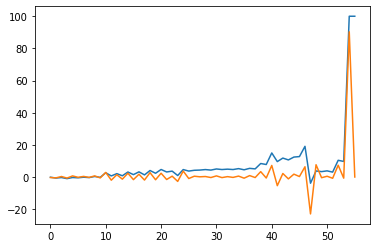

In [245]:
def get_engine_eval_difference_series(engine_series, engine_starting):
    diff_series = [engine_starting] + engine_series[:-1]
    print(engine_series[1], diff_series[1])
    return [ item[0]-item[1] for item in zip(engine_series, diff_series) ]


ex_series = get_engine_eval_difference_series(engine_series_list[-6], engine_starting)
pd.Series(engine_series_list[-6]).plot()
pd.Series(ex_series).plot()

### With all these functions and plots to help detect issues, I started aggregating games by opening moves. The function allows you to get the first n moves from each game. I chose the first two moves as that seems to be relatively indicative at my level of the type of game. Using this aggregation, I wrote a function to turn this into a pandas dataframe for easy analysis.

### After reading the book "Side-stepping Mainline Theory" by Welling and Giddins (I really recommend their book as it was really good for beginners like me), I changed my opening repetoire to use their recommended Old Indian setup. I would say I started using it approximately 150 games or so ago, so I chose only to look at those games. 


In [246]:
def aggregate_first_n_moves(game, n):
    moves = [ move['move_alg'] for move in game['move_descriptions'][:n] ]
    return (
        game['player_color'], 
        game['opponent'],
        game['elo_differential'],
        game['time_class'], 
        game['date'], 
        game['result'],  
        game['move_descriptions'][n-1]['player_engine_eval'],
        moves
    )

def build_dataframe_from_move_aggregation(agg_list):
    out_df = pd.DataFrame(
        agg_list, 
        columns=[
            'player_color', 'opponent', 'elo_differential', 'time_class', 'date', 'result', 'evaluation', 'opening'
        ]
    )
    out_df['opening_str'] = out_df['opening'].apply(lambda x: "".join(x))
    out_df['is_win'] = out_df['result'].apply(lambda x: 1 if x=='win' else 0)
    return out_df

#Just want to look at recent games so I limit to the last 150 games
openings_aggregated = [ aggregate_first_n_moves(game, 2) for game in parsed_games[-150:] ]
openings_df = build_dataframe_from_move_aggregation(openings_aggregated)
openings_df.head()

player_color            opponent  elo_differential time_class        date  \
0        white             1c3burg               -33      blitz  2021-03-28   
1        white  alexandrelaguardia                -7      blitz  2021-03-28   
2        black          JSalvarrey               -36      rapid  2021-03-29   
3        white       eugenesimakin                77      rapid  2021-03-29   
4        black          RuslanA123               -42      blitz  2021-03-29   

       result                     evaluation    opening opening_str  is_win  
0         win   {'type': 'p', 'value': 0.43}   [e4, c5]        e4c5       1  
1         win   {'type': 'p', 'value': 0.55}   [e4, e5]        e4e5       1  
2  checkmated  {'type': 'p', 'value': -0.32}  [d4, Nf6]       d4Nf6       0  
3         win   {'type': 'p', 'value': 0.65}   [e4, d6]        e4d6       1  
4         win  {'type': 'p', 'value': -0.32}  [d4, Nf6]       d4Nf6       1

### Now that it's a in a pandas dataframe we can do all the types of analytics we would usually do. I'm interested in detecting inefficiencies for certain white openings, so I do a groupby to get the win percentage and number of games for each of the openings.

### I do really well at King's pawn (1. e4 e5) and openings involving d-pawn moves (Pirc and Scandinavian), but have my worst games against the Sicilian (1. e4 c5 ) and also have a good number of games where I do okay against the Caro-Kann (1. e4 c6).

In [247]:
openings_df.groupby(['player_color', 'opening_str']).aggregate({'is_win': 'mean', 'opening_str': 'size'})

is_win  opening_str
player_color opening_str                       
black        Nf3Nf6       1.000000            1
             Nf3d6        1.000000            1
             b4Nf6        1.000000            1
             c4Nf6        1.000000            2
             c4e5         1.000000            1
             d4Nf6        0.458333           24
             d4d6         0.000000            1
             e4d6         0.488372           43
             e4e5         1.000000            1
white        e4Nc6        0.500000            2
             e4Nh6        0.000000            1
             e4c5         0.375000            8
             e4c6         0.500000            8
             e4d5         0.600000            5
             e4d6         0.600000            5
             e4e5         0.605263           38
             e4e6         0.571429            7
             e4g6         0.000000            1

### I then construct a function to get games with specific openings. As we saw above the interesting games were the ones against the Sicilian and the Caro-Kann, so I find those games.

In [248]:
def game_has_move_order(parsed_game, moves):
    for i, move in enumerate(moves):
        if parsed_game['move_descriptions'][i]['move_alg'] != move:
            return False
    return True

def find_games_with_move_order(games, moves):
    is_moves = [ game_has_move_order(game, moves) for game in games]
    has_move_order = []
    for i, item in enumerate(is_moves):
        if item:
            has_move_order.append(games[i])
    return has_move_order

#Just looking at last 150 games to look for recent mistakes
sicilian_games = find_games_with_move_order(parsed_games[-150:], ['e4', 'c5'])
caro_games = find_games_with_move_order(parsed_games[-150:], ['e4', 'c6'])

print(f'Found {len(sicillian_games)} sicilian games')
print(f'Found {len(caro_games)} caro games')

Found 8 sicilian games
Found 8 caro games


### I want to look a little further than the first two moves for these games, so I get the first ten moves for these games and do the same aggregation as before to get a dataframe. Here's the Sicilian games.

In [254]:
sicilian_agg = [ aggregate_first_n_moves(game, 10) for game in sicilian_games ]
sicilian_df = build_dataframe_from_move_aggregation(sicilian_agg)
sicilian_df['game_type'] = 'sicilian'
sicilian_df

player_color      opponent  elo_differential time_class        date  \
0        white       1c3burg               -33      blitz  2021-03-28   
1        white   grannysbuds                -6      rapid  2021-04-12   
2        white     faridnaas               -60      blitz  2021-04-25   
3        white  Rez_Rouzegar                66      blitz  2021-04-27   
4        white      RMKILLER                 4      blitz  2021-04-29   
5        white    foosmaster               -27      rapid  2021-05-03   
6        white     knightly1               -85      blitz  2021-05-04   
7        white     snelsonAU                52      blitz  2021-05-05   

       result                     evaluation  \
0         win  {'type': 'p', 'value': -0.11}   
1  checkmated  {'type': 'p', 'value': -0.16}   
2    resigned  {'type': 'p', 'value': -0.11}   
3         win   {'type': 'p', 'value': -0.1}   
4    resigned  {'type': 'p', 'value': -0.12}   
5  checkmated   {'type': 'p', 'value': 1.22}   
6  checkmated  {'type': 'p', 'value': -0.03}   
7         win   {'type': 'p', 'value': 1.36}   

                                          opening                 opening_str  \
0  [e4, c5, Nf3, d6, d3, Nc6, Nbd2, g6, Be2, Bg7]  e4c5Nf3d6d3Nc6Nbd2g6Be2Bg7   
1  [e4, c5, d3, d6, Nf3, Nf6, Nbd2, g6, Be2, Bg7]  e4c5d3d6Nf3Nf6Nbd2g6Be2Bg7   
2  [e4, c5, Nf3, Nc6, d3, d6, Nbd2, g6, Be2, Bg7]  e4c5Nf3Nc6d3d6Nbd2g6Be2Bg7   
3   [e4, c5, Nf3, e6, d3, d5, Nbd2, d4, Be2, Nc6]   e4c5Nf3e6d3d5Nbd2d4Be2Nc6   
4  [e4, c5, Nf3, d6, d3, g6, Be2, Nf6, Nbd2, Bg7]  e4c5Nf3d6d3g6Be2Nf6Nbd2Bg7   
5  [e4, c5, Nf3, d6, d3, Bg4, Nbd2, h5, Be2, Nf6]  e4c5Nf3d6d3Bg4Nbd2h5Be2Nf6   
6  [e4, c5, Nf3, Nc6, d3, g6, Nbd2, Bg7, Be2, d6]  e4c5Nf3Nc6d3g6Nbd2Bg7Be2d6   
7  [e4, c5, Nf3, Nc6, d3, e6, Nbd2, Nf6, Be2, g6]  e4c5Nf3Nc6d3e6Nbd2Nf6Be2g6   

   is_win game_type  
0       1  sicilian  
1       0  sicilian  
2       0  sicilian  
3       1  sicilian  
4       0  sicilian  
5       0  sicilian  
6       0  sicilian  
7       1  sicilian

In [255]:
caro_agg = [ aggregate_first_n_moves(game, 10) for game in caro_games ]
caro_df = build_dataframe_from_move_aggregation(caro_agg)
caro_df['game_type'] = 'caro'
caro_df

player_color            opponent  elo_differential time_class        date  \
0        white               EtPof               -42      blitz  2021-04-08   
1        white               ykeon                17      blitz  2021-04-08   
2        white         jkwonwilson               -51      blitz  2021-04-09   
3        white          brotherdad               -15      blitz  2021-04-09   
4        white           fecabanas               -62      rapid  2021-04-18   
5        white         Lycan_Frost               -76      blitz  2021-04-25   
6        white  rightingsonthewall                19      blitz  2021-04-28   
7        white     illadel_phinest               -61      rapid  2021-05-01   

       result                    evaluation  \
0         win  {'type': 'p', 'value': 0.33}   
1  checkmated  {'type': 'p', 'value': 1.79}   
2         win  {'type': 'p', 'value': 0.33}   
3         win  {'type': 'p', 'value': 1.96}   
4  checkmated  {'type': 'p', 'value': 0.81}   
5  checkmated  {'type': 'p', 'value': 0.59}   
6         win  {'type': 'p', 'value': 0.79}   
7  checkmated   {'type': 'p', 'value': 1.8}   

                                             opening  \
0  [e4, c6, d4, d5, Nd2, dxe4, Nxe4, Nf6, Nxf6+, ...   
1      [e4, c6, Nf3, d5, d3, Nd7, Be2, e5, O-O, Bc5]   
2  [e4, c6, d4, d5, Nc3, dxe4, Nxe4, Nf6, Nxf6+, ...   
3      [e4, c6, d4, d5, Nd2, e6, Ngf3, Bb4, c3, Ba5]   
4     [e4, c6, d4, d5, Nd2, Nf6, Bd3, Bg4, Ngf3, e6]   
5  [e4, c6, Nf3, d5, d3, dxe4, dxe4, Qxd1+, Kxd1,...   
6      [e4, c6, Nf3, d5, d3, b6, Nbd2, Nd7, Be2, e5]   
7     [e4, c6, Nf3, Nf6, d3, d6, Nbd2, b5, Be2, Qb6]   

                       opening_str  is_win game_type  
0  e4c6d4d5Nd2dxe4Nxe4Nf6Nxf6+exf6       1      caro  
1        e4c6Nf3d5d3Nd7Be2e5O-OBc5       0      caro  
2  e4c6d4d5Nc3dxe4Nxe4Nf6Nxf6+exf6       1      caro  
3        e4c6d4d5Nd2e6Ngf3Bb4c3Ba5       1      caro  
4       e4c6d4d5Nd2Nf6Bd3Bg4Ngf3e6       0      caro  
5   e4c6Nf3d5d3dxe4dxe4Qxd1+Kxd1e6       0      caro  
6        e4c6Nf3d5d3b6Nbd2Nd7Be2e5       1      caro  
7       e4c6Nf3Nf6d3d6Nbd2b5Be2Qb6       0      caro

### We concatenate these dataframes together and sort looking at the newest games first. In all of these games, I responded Nf3 to these c-file moves. I checked the tables of main variations from the Welling and Giddins book to find I was making a mistake for the setup I was using.

### For Sicillians it listed the Alapin variation (2. c3) as the move order for the Old Indian setup, and for Caro-Kanns it listed the Breyer variation (2. d4).

### After losing some of these games and doing the game analysis on chess.com, Nf3 is the top line (1st or 2nd depending on depth) recommended by the engine, but because I'm doing a setup opening I would have never looked to this Nf3 move as a potential problem.

In [258]:
interesting_games = pd.concat([sicilian_df, caro_df])
interesting_games = interesting_games.sort_values(['date'], ascending=False)
interesting_games.head(10)

player_color            opponent  elo_differential time_class        date  \
7        white           snelsonAU                52      blitz  2021-05-05   
6        white           knightly1               -85      blitz  2021-05-04   
5        white          foosmaster               -27      rapid  2021-05-03   
7        white     illadel_phinest               -61      rapid  2021-05-01   
4        white            RMKILLER                 4      blitz  2021-04-29   
6        white  rightingsonthewall                19      blitz  2021-04-28   
3        white        Rez_Rouzegar                66      blitz  2021-04-27   
2        white           faridnaas               -60      blitz  2021-04-25   
5        white         Lycan_Frost               -76      blitz  2021-04-25   
4        white           fecabanas               -62      rapid  2021-04-18   

       result                     evaluation  \
7         win   {'type': 'p', 'value': 1.36}   
6  checkmated  {'type': 'p', 'value': -0.03}   
5  checkmated   {'type': 'p', 'value': 1.22}   
7  checkmated    {'type': 'p', 'value': 1.8}   
4    resigned  {'type': 'p', 'value': -0.12}   
6         win   {'type': 'p', 'value': 0.79}   
3         win   {'type': 'p', 'value': -0.1}   
2    resigned  {'type': 'p', 'value': -0.11}   
5  checkmated   {'type': 'p', 'value': 0.59}   
4  checkmated   {'type': 'p', 'value': 0.81}   

                                             opening  \
7     [e4, c5, Nf3, Nc6, d3, e6, Nbd2, Nf6, Be2, g6]   
6     [e4, c5, Nf3, Nc6, d3, g6, Nbd2, Bg7, Be2, d6]   
5     [e4, c5, Nf3, d6, d3, Bg4, Nbd2, h5, Be2, Nf6]   
7     [e4, c6, Nf3, Nf6, d3, d6, Nbd2, b5, Be2, Qb6]   
4     [e4, c5, Nf3, d6, d3, g6, Be2, Nf6, Nbd2, Bg7]   
6      [e4, c6, Nf3, d5, d3, b6, Nbd2, Nd7, Be2, e5]   
3      [e4, c5, Nf3, e6, d3, d5, Nbd2, d4, Be2, Nc6]   
2     [e4, c5, Nf3, Nc6, d3, d6, Nbd2, g6, Be2, Bg7]   
5  [e4, c6, Nf3, d5, d3, dxe4, dxe4, Qxd1+, Kxd1,...   
4     [e4, c6, d4, d5, Nd2, Nf6, Bd3, Bg4, Ngf3, e6]   

                      opening_str  is_win game_type  
7      e4c5Nf3Nc6d3e6Nbd2Nf6Be2g6       1  sicilian  
6      e4c5Nf3Nc6d3g6Nbd2Bg7Be2d6       0  sicilian  
5      e4c5Nf3d6d3Bg4Nbd2h5Be2Nf6       0  sicilian  
7      e4c6Nf3Nf6d3d6Nbd2b5Be2Qb6       0      caro  
4      e4c5Nf3d6d3g6Be2Nf6Nbd2Bg7       0  sicilian  
6       e4c6Nf3d5d3b6Nbd2Nd7Be2e5       1      caro  
3       e4c5Nf3e6d3d5Nbd2d4Be2Nc6       1  sicilian  
2      e4c5Nf3Nc6d3d6Nbd2g6Be2Bg7       0  sicilian  
5  e4c6Nf3d5d3dxe4dxe4Qxd1+Kxd1e6       0      caro  
4      e4c6d4d5Nd2Nf6Bd3Bg4Ngf3e6       0      caro

### I decided to stop the analysis here after finding this alternative variations for further study and practice, but one can definitely take this inter-game analysis further.

### While the chess.com game analysis is very good at learning mistakes from games, the analytics are a bit lacking for these type of high-level searches for problems with habits and move orders in multiple games. 

### After doing this analysis on my games what types of problems would I recommend using the API to look at your games? Here's a non-exhaustive list:
1. Checking for patterns or innefficiencies in your openings between many games
2. Searching for habits of tactical mistakes in middlegames
3. Performing tasks similar to chess.com's opening database, but needing custom filtering on games beyond what they offer

### Some other ideas of what can be done using the API:
1. Build a crawler starting with your games and going out to games of people you played and people they played, etc. to build a database of games at similar ELO to get a general understading of the meta at a certain ELO
2. Using previous game data to build a chess trainer (Here's an example app [https://vitogit.github.io/vue-chess-guardian/])
3. Build a better analysis tool to help automatically detect bad habits previously seen in games

